## Gaussian processes 

* Great [lecture](https://www.youtube.com/watch?v=92-98SYOdlY) by Richard Turner on GP basics. 
* Jupyter notebook adaption of that lecture: [Link](https://yugeten.github.io/posts/2019/09/GP/)

In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import clear_output

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
np.random.seed(42)

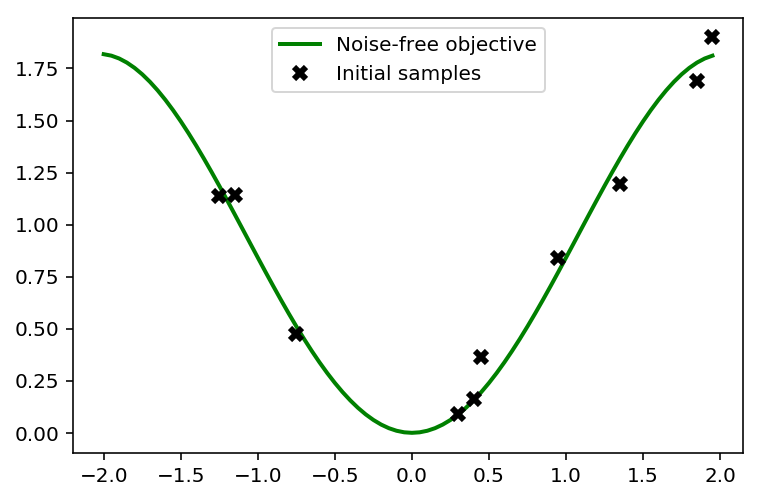

In [3]:
#Define a objective function -- in real case we have this a 'black-box'
def f(X, f_noise):
    return  X * np.sin(X) + f_noise * np.random.randn(*X.shape) 

noise = 0.1
bounds = np.array([[-2.0, 2.0]])
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.05).reshape(-1, 1)
# Noise-free objective function values at X 
Y = f(X,0.0)

#X_init = np.array([[-0.9],[1.1]])
random_indices_X = np.random.choice(len(X),size=10, replace=False)
X_init = X[random_indices_X]
Y_init = f(X_init, noise)



# Plot optimization objective with noise level 
plt.plot(X, Y, 'g-', linewidth=2, label='Noise-free objective')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [4]:
#Gaussian process with Matern kernel as surrogate model 
cMatern_kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) #Length-scale and nu=deviation from RBF
'''
Constant kernel: used as part of a product-kernel where it scales the magnitude of 
the other factor (usually a kernel)
'''
gpr = GaussianProcessRegressor(kernel=cMatern_kernel, alpha=noise**2)
gpr.fit(X_init, Y_init);

In [5]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    # Calculate the error metrics
    mae = mean_absolute_error(Y, mu)
    rmse = np.sqrt(mean_squared_error(Y,mu))
    
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1, label='95% confidence interval') 
    plt.plot(X, Y, 'r-', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b--', lw=1.5, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if show_legend:
        text = ('    MAE = %.2f\n    RMSE = %.2f\n'% (mae, rmse))
        plt.text(x=1.0, y=2.5, s=text, horizontalalignment='left',verticalalignment='top')
        plt.legend()

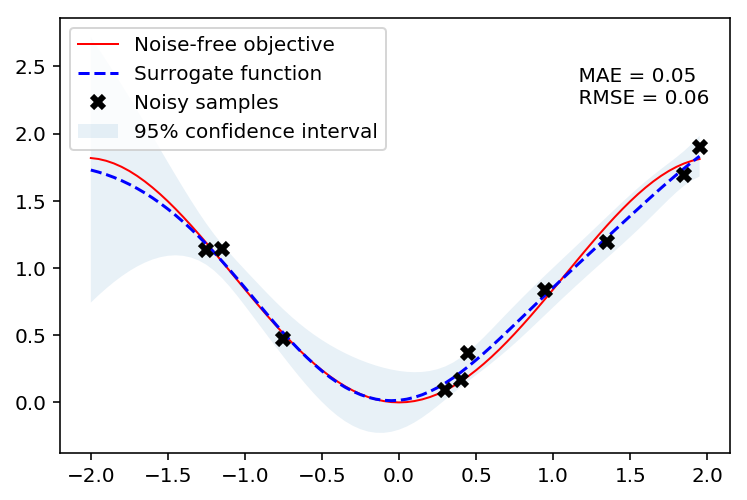

In [6]:
plot_approximation(gpr, X, Y, X_init, Y_init, show_legend=True)

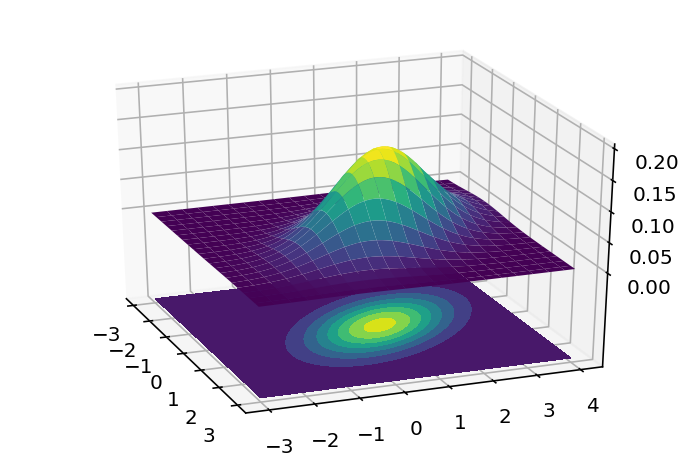

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.7], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()